In [33]:
import numpy as np
import pandas as pd
import datetime as dt
import xlrd
import xlsxwriter
from collections import OrderedDict
import sys
# from utils import frames_to_excel, dictmap_load, dictmap_datetime
import copy
from statsmodels.robust import mad
from monthdelta import monthdelta
import sklearn
import tensorflow as tf
import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard
from time import time
from sklearn import preprocessing


In [3]:
raw_xlsx_file = pd.ExcelFile("data/interim/clean_data.xlsx")
dict_dataframes =pd.read_excel(raw_xlsx_file,sheet_name = None)
dict_dataframes_index =  copy.deepcopy(dict_dataframes)

In [4]:
df = dict_dataframes_index['nifty 50 index data']

In [5]:
df['date'] = pd.to_datetime(df['date'].astype(str),format='%Y-%m-%d')

In [6]:
df = df.set_index('date')

In [7]:
df.shape

(2043, 19)

In [8]:
df.head()

,open,high,low,close,volume,macd,cci,atr,boll_mid,ema20,ma5,ma10,mtm6,mtm12,roc,smi,wvad,us dollar index,interbank offered rate
date,,,,,,,,,,,,,,,,,,,
2008-07-01,4039.75,4075.40,3878.20,3896.75,164469220,-201.56,-180.03,197.2,4409.04,4385.058946,4128.49,4253.415,-369.65,-620.35,-13.733369,-0.149627,-828023961.0,72.34,8.706
2008-07-02,3895.30,4107.15,3848.25,4093.35,199920144,-199.63,-131.91,258.9,4384.43,4357.277142,4096.63,4204.510,-97.75,-479.15,-10.478950,-0.091225,-561033032.0,71.99,7.730
2008-07-03,4094.60,4097.35,3874.85,3925.75,154573765,-209.21,-129.55,222.5,4346.87,4316.179319,4018.61,4146.660,-326.90,-727.25,-15.629701,-0.097020,-726253640.3,72.73,6.400
2008-07-04,3926.65,4033.50,3896.40,4016.00,152045352,-207.14,-111.08,137.1,4316.28,4287.590812,3994.48,4113.505,-299.85,-566.40,-12.360335,-0.058691,-548766472.1,72.71,6.210
2008-07-07,4002.00,4114.50,4002.00,4030.00,125737237,-202.03,-80.86,112.5,4292.73,4263.058354,3992.37,4089.865,-106.65,-474.25,-10.528945,-0.038439,-486195115.1,72.71,9.000


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0,0.5,'Close Price')

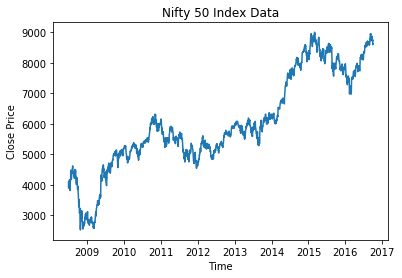

In [10]:
plt.title('Nifty 50 Index Data')
plt.plot(df.index,df['close'])
plt.xlabel('Time')
plt.ylabel('Close Price')

In [11]:
X_df = df.values
print(X_df.shape)
print(X_df)

(2043, 19)
[[ 4.03975000e+03  4.07540000e+03  3.87820000e+03 ... -8.28023961e+08
   7.23400000e+01  8.70600000e+00]
 [ 3.89530000e+03  4.10715000e+03  3.84825000e+03 ... -5.61033032e+08
   7.19900000e+01  7.73000000e+00]
 [ 4.09460000e+03  4.09735000e+03  3.87485000e+03 ... -7.26253640e+08
   7.27300000e+01  6.40000000e+00]
 ...
 [ 8.71120000e+03  8.76705000e+03  8.70315000e+03 ... -4.44559525e+08
   9.54275000e+01  6.54000000e+00]
 [ 8.79270000e+03  8.80065000e+03  8.55825000e+03 ... -7.70928359e+08
   9.55172000e+01  6.52000000e+00]
 [ 8.58150000e+03  8.63715000e+03  8.55520000e+03 ... -5.33705581e+08
   9.54426000e+01  6.52000000e+00]]


In [12]:
import pywt as py

In [13]:
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=6)
train_list = []
test_list = []
for train_index,test_index in splits.split(X_df):
    train = X_df[train_index]
    test = X_df[test_index]
    train_list.append(train)
    test_list.append(test)
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))   

Observations: 588
Training Observations: 297
Testing Observations: 291
Observations: 879
Training Observations: 588
Testing Observations: 291
Observations: 1170
Training Observations: 879
Testing Observations: 291
Observations: 1461
Training Observations: 1170
Testing Observations: 291
Observations: 1752
Training Observations: 1461
Testing Observations: 291
Observations: 2043
Training Observations: 1752
Testing Observations: 291


Text(0,0.5,'Close price')

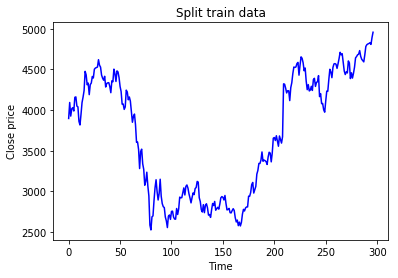

In [14]:
train_plt = np.array(train_list[0])
plt.plot(train_plt[:,3],'blue')
plt.title('Split train data')
plt.xlabel('Time')
plt.ylabel('Close price')

In [15]:
cA2,cD2,cD1 = py.wavedec(X_df,'haar',level=2,axis=0)
print(cA2.shape,cD2.shape,cD1.shape)

(511, 19) (511, 19) (1022, 19)


In [16]:
coeffs = cA2,cD2,cD1
X_df_reconst = py.waverec(coeffs,'haar',axis=0)
X_df_reconst.shape

(2044, 19)

In [17]:
#--------------New-----------------------

coeff = py.wavedec(X_df,'haar',level=2,axis=0)
cA2, cD2, cD1 = coeff
print(cA2.shape,cD2.shape,cD1.shape)

(511, 19) (511, 19) (1022, 19)


In [18]:
# cat = py.threshold(cA2,np.std(cA2)/2,mode='soft')
# cad2 = py.threshold(cD2,np.std(cD2)/2,mode='soft')
# cad1 = py.threshold(cD2,np.std(cD1)/2,mode='soft')
# print(cat.shape,cad2.shape,cad1.shape)

In [19]:
sigma = mad(coeff[-1])
uthresh = sigma * np.sqrt( 2*np.log( len( X_df ) ) )
print(cA2.shape,cD2.shape,cD1.shape)

(511, 19) (511, 19) (1022, 19)


In [20]:
coeff[1:] = (py.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )

In [21]:
print(coeff[2].shape)
y = py.waverec( coeff, 'haar', mode="per",axis=0 )

(1022, 19)


(2000, 5000)

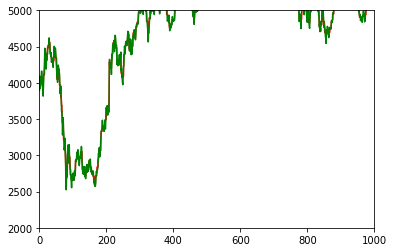

In [116]:
plt.plot(y[:,3],'red')
plt.plot(X_df[:,3],'green')
plt.xlim([0,1000])
plt.ylim([2000,5000])

In [23]:
def interval_split(df):
    df_list = {}
    split_count = 3
    month_increment = 0
    interval_index = 0
    while split_count > 0:
        front = df.index[0]
        front = front + monthdelta(month_increment)
        back = df.index[0] + monthdelta(30)
        back = back + monthdelta(month_increment)
        dataframe_interval = pd.DataFrame(df[(df.index >= front) &(df.index < back)])
        df_list[interval_index] = dataframe_interval
        split_count -= 1
        month_increment +=3
        interval_index +=1
#         print('front:',front,'back:',back)
#         print(len(df_list))

    return df_list

df_list = interval_split(df)
# df.head()

In [36]:
# df_list[0].head
#Train
# df_train.head()
# print(df_train.shape,df_val.shape,df_test.shape)

def tvt_split(df):
    df_tvt = {}
    train = df.index[0]
    val = df.index[0] + monthdelta(24)
    test = df.index[0] + monthdelta(27)
    test_end = df.index[0] + monthdelta(30)
    df_train = pd.DataFrame(df[(df.index >= train) &(df.index <= val)])
    df_val = pd.DataFrame(df[(df.index >= val) &(df.index <= test)])
    df_test = pd.DataFrame(df[(df.index >= test) &(df.index <= test_end)])
    df_tvt = {1:df_train,2:df_val,3:df_test}
    print(test_end -test)
    return df_tvt
df_tvt = tvt_split(df_list[0])

92 days 00:00:00


In [37]:
# Validation 
df_train = df_tvt[1]
df_val = df_tvt[2]
df_test = df_tvt[3]
print(df_train.shape,df_val.shape,df_test.shape)

(490, 19) (66, 19) (64, 19)


In [26]:
input_dim = df_train.shape[1]
hidden_dim = 20
input_data = Input(shape=(input_dim,))

#layer 1
encoded = Dense(hidden_dim,activation='sigmoid')(input_data)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
#layer 2
encoded = Dense(hidden_dim,activation='sigmoid')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

#layer 3
encoded = Dense(hidden_dim,activation='sigmoid')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
#layer 4
encoded = Dense(hidden_dim,activation='sigmoid')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
#layer 5
encoded = Dense(hidden_dim,activation='sigmoid')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_data,decoded)
autoencoder.compile(optimizer='sgd',loss='mse',metrics=['accuracy'])
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 19)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                200       
_________________________________________________________________
dense_2 (Dense)              (None, 19)                209       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                200       
_________________________________________________________________
dense_4 (Dense)              (None, 19)                209       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                200       
_________________________________________________________________
dense_6 (Dense)              (None, 19)                209 

In [27]:
autoencoder.fit(df_train, df_train, epochs=10,verbose=2)
# autoencoder.evaluate(df_train,df_train)

Epoch 1/10
 - 2s - loss: 36521758324048072.0000 - accuracy: 0.4776
Epoch 2/10
 - 0s - loss: 36521757377402224.0000 - accuracy: 0.4857
Epoch 3/10
 - 0s - loss: 36521758499352856.0000 - accuracy: 0.4857
Epoch 4/10
 - 0s - loss: 36521758166273768.0000 - accuracy: 0.4857
Epoch 5/10
 - 0s - loss: 36521757868255624.0000 - accuracy: 0.4857
Epoch 6/10
 - 0s - loss: 36521757491350328.0000 - accuracy: 0.4857
Epoch 7/10
 - 0s - loss: 36521757999734216.0000 - accuracy: 0.4857
Epoch 8/10
 - 0s - loss: 36521758288987112.0000 - accuracy: 0.4857
Epoch 9/10
 - 0s - loss: 36521757973438496.0000 - accuracy: 0.4857
Epoch 10/10
 - 0s - loss: 36521758560709536.0000 - accuracy: 0.4857


In [28]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [29]:
autoencoder.fit(df_train, df_train, epochs=10,verbose=2,callbacks=[tensorboard])

Epoch 1/10
 - 0s - loss: 36521757903316584.0000 - accuracy: 0.4857
Epoch 2/10
 - 0s - loss: 36521757938377536.0000 - accuracy: 0.4857
Epoch 3/10
 - 0s - loss: 36521757342341264.0000 - accuracy: 0.4857
Epoch 4/10
 - 0s - loss: 36521758885023392.0000 - accuracy: 0.4857
Epoch 5/10
 - 0s - loss: 36521757859490384.0000 - accuracy: 0.4857
Epoch 6/10
 - 0s - loss: 36521757938377536.0000 - accuracy: 0.4857
Epoch 7/10
 - 0s - loss: 36521757614063680.0000 - accuracy: 0.4857
Epoch 8/10
 - 0s - loss: 36521758113682328.0000 - accuracy: 0.4857
Epoch 9/10
 - 0s - loss: 36521757933994920.0000 - accuracy: 0.4857
Epoch 10/10
 - 0s - loss: 36521758069856128.0000 - accuracy: 0.4857


In [30]:
autoencoded_data = pd.DataFrame(autoencoder.predict(df_train))

In [31]:
autoencoded_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.999885,0.999886,0.999883,0.999885,1.0,0.918215,0.952581,0.995268,0.999884,0.999884,0.999885,0.999884,0.94297,0.974452,0.390694,0.347301,1.0,0.993586,0.823718
1,0.999885,0.999886,0.999883,0.999885,1.0,0.918215,0.952581,0.995268,0.999884,0.999884,0.999885,0.999884,0.94297,0.974452,0.390694,0.347301,1.0,0.993586,0.823718
2,0.999885,0.999886,0.999883,0.999885,1.0,0.918215,0.952581,0.995268,0.999884,0.999884,0.999885,0.999884,0.94297,0.974452,0.390694,0.347301,1.0,0.993586,0.823718
3,0.999885,0.999886,0.999883,0.999885,1.0,0.918215,0.952581,0.995268,0.999884,0.999884,0.999885,0.999884,0.94297,0.974452,0.390694,0.347301,1.0,0.993586,0.823718
4,0.999885,0.999886,0.999883,0.999885,1.0,0.918215,0.952581,0.995268,0.999884,0.999884,0.999885,0.999884,0.94297,0.974452,0.390694,0.347301,1.0,0.993586,0.823718


In [46]:
print(df_train.shape,df_val.shape,df_test.shape)
print(df_train.iloc[0:10,1:5])

(490, 19) (66, 19) (64, 19)
               high      low    close     volume
date                                            
2008-07-01  4075.40  3878.20  3896.75  164469220
2008-07-02  4107.15  3848.25  4093.35  199920144
2008-07-03  4097.35  3874.85  3925.75  154573765
2008-07-04  4033.50  3896.40  4016.00  152045352
2008-07-07  4114.50  4002.00  4030.00  125737237
2008-07-08  4028.70  3896.05  3988.55  135090953
2008-07-09  4169.40  3990.90  4157.10  144597409
2008-07-10  4187.95  4110.40  4162.20  146458190
2008-07-11  4215.50  4014.45  4049.00  137337875
2008-07-14  4118.10  4004.25  4039.70  126882896


In [63]:
robustscaler = preprocessing.RobustScaler()
df_train_scaled = pd.DataFrame(robustscaler.fit_transform(df_train),
                              columns = list(df_train.columns),
                               index=list(df_train.index))
df_train_scaled.index.name = 'date'
# print(robustscaler.center_,robustscaler.scale_)

[4.48162500e+03 4.54242500e+03 4.40530000e+03 4.48315000e+03
 2.18858788e+08 2.07200000e+01 3.52300000e+01 9.52750000e+01
 4.41616000e+03 4.37865486e+03 4.48593500e+03 4.46160750e+03
 2.98250000e+01 4.59000000e+01 1.17092799e+00 7.88236700e-03
 2.41823830e+08 8.03800000e+01 3.60000000e+00] [1.63052500e+03 1.57762500e+03 1.64436250e+03 1.63137500e+03
 1.15216759e+08 1.10345000e+02 1.80232500e+02 6.35625000e+01
 1.57723250e+03 1.61993580e+03 1.63193500e+03 1.62728750e+03
 2.37925000e+02 3.86075000e+02 9.02308958e+00 6.67386572e-02
 1.04196878e+09 7.17750000e+00 2.19500000e+00]


In [60]:
df_train_scaled.iloc[0:10,1:5]

,high,low,close,volume
date,,,,
2008-07-01,-0.296030,-0.320550,-0.359451,-0.472063
2008-07-02,-0.275905,-0.338764,-0.238940,-0.164374
2008-07-03,-0.282117,-0.322587,-0.341675,-0.557949
2008-07-04,-0.322589,-0.309482,-0.286354,-0.579893
2008-07-07,-0.271246,-0.245262,-0.277772,-0.808229
2008-07-08,-0.325632,-0.309694,-0.303180,-0.727046
2008-07-09,-0.236447,-0.252013,-0.199862,-0.644536
2008-07-10,-0.224689,-0.179340,-0.196736,-0.628386
2008-07-11,-0.207226,-0.237691,-0.266125,-0.707544


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4d7d84d0>,
      dtype=object)

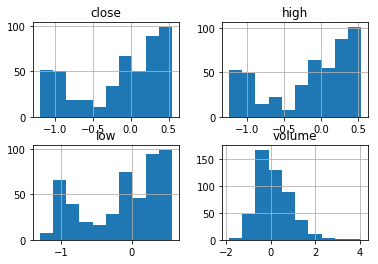

In [67]:
df_train_scaled[['high','low','close','volume']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4dd6c990>,
      dtype=object)

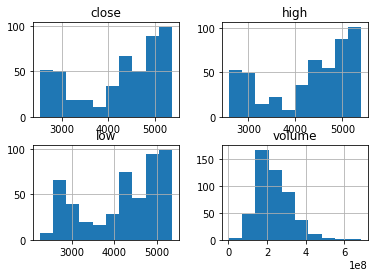

In [68]:
df_train[['high','low','close','volume']].hist()

In [69]:
def scaling_robust(df):
    scaling = preprocessing.RobustScaler()
    df = pd.DataFrame(scaling.fit_transform(df),columns=list(df.columns)
                     ,index=list(df.index))
    df.index.name = 'date'
    return df
df_train_scaled = scaling_robust(df_train)

In [71]:
# print(df_train_scaled.head())
df_val_scaled = scaling_robust(df_val)
df_test_scaled = scaling_robust(df_test)

In [76]:
print(df_train.shape,df_val.shape,df_test.shape)

(490, 19) (66, 19) (64, 19)


In [83]:
def wavelet_smoothing(df):
    coeff = py.wavedec(df,'haar',level=2,axis=0)
    sigma = mad(coeff[-1])
    upper_thresh = sigma*np.sqrt(2*np.log(len(df)))
    coeff[1:] = (py.threshold( i, value=uthresh, mode="soft" )
                 for i in coeff[1:] )
    y = py.waverec( coeff, 'haar', mode="per",axis=0 )
    df_smooth = pd.DataFrame(y,columns=list(df.columns)
                     ,index=list(df.index))
    df_smooth.index.name = 'date'
    return df_smooth

df_train_scaled_smooth = wavelet_smoothing(df_train_scaled)


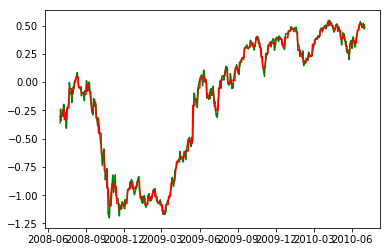

In [86]:
plt.plot(df_train_scaled['close'],'g')
plt.plot(df_train_scaled_smooth['close'],'r')

In [87]:
df_test_scaled_smooth = wavelet_smoothing(df_test_scaled)
df_val_scaled_smooth = wavelet_smoothing(df_val_scaled)

In [88]:
df_val_scaled_smooth.head()

,open,high,low,close,volume,macd,cci,atr,boll_mid,ema20,ma5,ma10,mtm6,mtm12,roc,smi,wvad,us dollar index,interbank offered rate
date,,,,,,,,,,,,,,,,,,,
2010-07-01,-0.954384,-0.950874,-0.998931,-0.958394,-0.702129,0.155942,-0.718489,-0.156130,-1.430496,-1.339425,-1.248437,-1.682280,-0.627931,-0.424805,-0.404754,-0.603026,0.243946,1.112536,-0.086901
2010-07-02,-0.954384,-0.950874,-0.998931,-0.958394,-0.702129,0.155942,-0.718489,-0.156130,-1.430496,-1.339425,-1.248437,-1.682280,-0.627931,-0.424805,-0.404754,-1.389932,0.243946,1.112536,-0.086901
2010-07-05,-0.954384,-0.950874,-0.998931,-0.958394,-0.702129,0.155942,-0.718489,-0.156130,-1.430496,-1.339425,-1.248437,-1.682280,-0.627931,-0.424805,-0.404754,-1.148978,0.243946,1.112536,0.278738
2010-07-06,-0.954384,-0.950874,-0.998931,-0.958394,-0.702129,0.155942,-0.718489,-0.156130,-1.430496,-1.339425,-1.248437,-1.682280,-0.627931,-0.424805,-0.404754,-0.828966,0.243946,1.112536,0.278738
2010-07-07,-0.766662,-0.659889,-0.735919,-0.642614,0.285671,-0.164306,-0.083174,0.083269,-1.105470,-1.210512,-1.212370,-1.827147,0.078757,-0.531847,-0.509794,-1.097894,0.198409,0.901709,-0.006803


In [115]:
def stack_encoder(df,n_epoch,activation):
    input_dim = df_train.shape[1]
    hidden_dim = 10
    input_data = Input(shape=(input_dim,))

#layer 1
    encoded = Dense(hidden_dim,activation=activation)(input_data)
    decoded = Dense(input_dim, activation=activation)(encoded)
#layer 2
#     encoded = Dense(hidden_dim,activation=activation)(decoded)
#     decoded = Dense(input_dim, activation=activation)(encoded)

# #layer 3
#     encoded = Dense(hidden_dim,activation=activation)(decoded)
#     decoded = Dense(input_dim, activation=activation)(encoded)
# #layer 4
#     encoded = Dense(hidden_dim,activation=activation)(decoded)
#     decoded = Dense(input_dim, activation=activation)(encoded)
#layer 5
#     encoded = Dense(hidden_dim,activation=activation)(decoded)
#     decoded = Dense(input_dim, activation=activation)(encoded)

    autoencoder = Model(input_data,decoded)
    autoencoder.compile(optimizer='sgd',
                        loss='mse',metrics=['accuracy'])
#     autoencoder.summary()
    tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
    autoencoder.fit(df_train, df_train, epochs=n_epoch,verbose=2,
                callbacks=[tensorboard])
    autoencoded_data = pd.DataFrame(autoencoder.predict(df_train),
                                   columns=list(df.columns)
                     ,index=list(df.index))
    autoencoded_data.index.name = 'date'
    return autoencoded_data

df_train_scaled_smooth_encoded = stack_encoder(df_train_scaled_smooth
                                               ,50,'sigmoid')
    

Epoch 1/50
 - 1s - loss: 36521757877020864.0000 - accuracy: 0.4571
Epoch 2/50
 - 0s - loss: 36521757324810784.0000 - accuracy: 0.4857
Epoch 3/50
 - 0s - loss: 36521758516883336.0000 - accuracy: 0.4857
Epoch 4/50
 - 0s - loss: 36521757605298440.0000 - accuracy: 0.4857
Epoch 5/50
 - 0s - loss: 36521758429230944.0000 - accuracy: 0.4857
Epoch 6/50
 - 0s - loss: 36521757622828920.0000 - accuracy: 0.4857
Epoch 7/50
 - 0s - loss: 36521757622828920.0000 - accuracy: 0.4857
Epoch 8/50
 - 0s - loss: 36521758420465704.0000 - accuracy: 0.4857
Epoch 9/50
 - 0s - loss: 36521757657889880.0000 - accuracy: 0.4857
Epoch 10/50
 - 0s - loss: 36521757535176528.0000 - accuracy: 0.4857
Epoch 11/50
 - 0s - loss: 36521758069856128.0000 - accuracy: 0.4857
Epoch 12/50
 - 0s - loss: 36521757763072752.0000 - accuracy: 0.4857
Epoch 13/50
 - 0s - loss: 36521757745542272.0000 - accuracy: 0.4857
Epoch 14/50
 - 0s - loss: 36521757885786104.0000 - accuracy: 0.4857
Epoch 15/50
 - 0s - loss: 36521758411700464.0000 - accura

In [105]:
df_val_scaled_smooth_encoded = stack_encoder(df_val_scaled_smooth
                                               ,50,'sigmoid')
df_test_scaled_smooth_encoded = stack_encoder(df_test_scaled_smooth
                                               ,50,'sigmoid')

Epoch 1/50
 - 2s - loss: 36521757622828920.0000 - accuracy: 0.4490
Epoch 2/50
 - 0s - loss: 36521757929612304.0000 - accuracy: 0.4857
Epoch 3/50
 - 0s - loss: 36521757508880808.0000 - accuracy: 0.4857
Epoch 4/50
 - 0s - loss: 36521757885786104.0000 - accuracy: 0.4857
Epoch 5/50
 - 0s - loss: 36521758464291904.0000 - accuracy: 0.4857
Epoch 6/50
 - 0s - loss: 36521758411700464.0000 - accuracy: 0.4857
Epoch 7/50
 - 0s - loss: 36521757675420360.0000 - accuracy: 0.4857
Epoch 8/50
 - 0s - loss: 36521757763072752.0000 - accuracy: 0.4857
Epoch 9/50
 - 0s - loss: 36521758350343792.0000 - accuracy: 0.4857
Epoch 10/50
 - 0s - loss: 36521757938377536.0000 - accuracy: 0.4857
Epoch 11/50
 - 0s - loss: 36521758648361928.0000 - accuracy: 0.4857
Epoch 12/50
 - 0s - loss: 36521758218865200.0000 - accuracy: 0.4857
Epoch 13/50
 - 0s - loss: 36521757149505992.0000 - accuracy: 0.4857
Epoch 14/50
 - 0s - loss: 36521758087386608.0000 - accuracy: 0.4857
Epoch 15/50
 - 0s - loss: 36521758043560408.0000 - accura

ValueError: Shape of passed values is (490, 19), indices imply (66, 19)

In [111]:
df_train_scaled_smooth_encoded.head()

,open,high,low,close,volume,macd,cci,atr,boll_mid,ema20,ma5,ma10,mtm6,mtm12,roc,smi,wvad,us dollar index,interbank offered rate
date,,,,,,,,,,,,,,,,,,,
2008-07-01,0.999969,0.999969,0.999969,0.999969,1.0,0.977218,0.987628,0.998762,0.999969,0.999969,0.999969,0.999969,0.988311,0.993501,0.538908,0.289696,1.0,0.998323,0.961796
2008-07-02,0.999969,0.999969,0.999969,0.999969,1.0,0.977218,0.987628,0.998762,0.999969,0.999969,0.999969,0.999969,0.988311,0.993501,0.538908,0.289696,1.0,0.998323,0.961796
2008-07-03,0.999969,0.999969,0.999969,0.999969,1.0,0.977218,0.987628,0.998762,0.999969,0.999969,0.999969,0.999969,0.988311,0.993501,0.538908,0.289696,1.0,0.998323,0.961796
2008-07-04,0.999969,0.999969,0.999969,0.999969,1.0,0.977218,0.987628,0.998762,0.999969,0.999969,0.999969,0.999969,0.988311,0.993501,0.538908,0.289696,1.0,0.998323,0.961796
2008-07-07,0.999969,0.999969,0.999969,0.999969,1.0,0.977218,0.987628,0.998762,0.999969,0.999969,0.999969,0.999969,0.988311,0.993501,0.538908,0.289696,1.0,0.998323,0.961796


In [112]:
df_train_scaled_smooth.head()

,open,high,low,close,volume,macd,cci,atr,boll_mid,ema20,ma5,ma10,mtm6,mtm12,roc,smi,wvad,us dollar index,interbank offered rate
date,,,,,,,,,,,,,,,,,,,
2008-07-01,-0.302081,-0.294161,-0.322845,-0.306605,-0.443570,-2.040011,-0.961938,1.709341,-0.032972,-0.026006,-0.261274,-0.173347,-1.275034,-1.668555,-1.576125,-2.310290,-0.871277,-1.105886,2.177968
2008-07-02,-0.302081,-0.294161,-0.322845,-0.306605,-0.443570,-2.040011,-0.961938,1.709341,-0.032972,-0.026006,-0.261274,-0.173347,-1.275034,-1.668555,-1.576125,-1.493550,-0.871277,-1.105886,1.906981
2008-07-03,-0.302081,-0.294161,-0.322845,-0.306605,-0.443570,-2.040011,-0.961938,1.709341,-0.032972,-0.026006,-0.261274,-0.173347,-1.275034,-1.668555,-1.576125,-1.563296,-0.871277,-1.105886,1.293744
2008-07-04,-0.302081,-0.294161,-0.322845,-0.306605,-0.443570,-2.040011,-0.961938,1.709341,-0.032972,-0.026006,-0.261274,-0.173347,-1.275034,-1.668555,-1.576125,-1.047325,-0.871277,-1.105886,1.293744
2008-07-07,-0.268203,-0.264504,-0.246577,-0.244387,-0.702049,-1.878857,-0.545212,0.486726,-0.098021,-0.086795,-0.282853,-0.243075,0.053851,-0.747944,-0.740368,-0.702609,-0.606531,-1.071752,2.477221
